In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('b_td_pred.csv', 'rb') as f:
    data = pd.read_csv(f)
    
seleted_data = data
    
seleted_data = data.drop(columns=['Year', 'Tourism_Numbers', 'Local', 'JNU_Composite', "Misc._Good_and_Services", 'Healthcare'])

In [4]:
# 2. 数据归一化
def normalize_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def normalize_mean_std_201(df):
    return (((df - df.mean()) / df.std()) + 1) / 2

def normalize_mean_std(df):
    return (df - df.mean()) / df.std()

normalized_data = normalize_mean_std(seleted_data)

In [5]:
# 3. 计算熵值
def calculate_entropy(df):
    # 转化为概率矩阵
    P = df / df.sum(axis=0)
    
    # 计算信息熵
    k = 1 / np.log(len(df))
    entropy = -k * (P * np.log(P + 1e-12)).sum(axis=0)
    return entropy

entropy = calculate_entropy(normalized_data)

c:\Users\19912\.conda\envs\data\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [6]:
# 4. 根据熵值计算权重
redundancy = 1 - entropy
weights = redundancy / redundancy.sum()

In [8]:
# 输出权重
print(weights)

print('-'*30)
print("weights.sum() == 1 ?")

print(weights.sum())

stsfy                                     0.029112
Crowding_at_Mendenhall_Glacier            0.029089
Crowding_on_sidewalks_downtown            0.002553
Vehicle_congestion_downtown               0.058313
Flightseeing_noise                        0.025751
Air_emissions_from_cruise_ships           0.139424
Vehicle_congestion_outside_of_downtown    0.129145
Whale_watching_boat_traffic_and_wakes     0.021685
Crowding_on_trails                        0.034678
Street_Services                           0.067125
Wastewater                                0.038384
Public_Transit                            0.012025
Parks_and_Recreation                      0.180182
Docks                                     0.024321
Ports                                     0.121009
Grocery_Items                             0.015780
JNU_Housing                               0.034101
Utilities                                 0.002685
Transportation                            0.034639
dtype: float64
----------------

In [9]:
# 微调权重
# weights["Vehicle_congestion_downtown"] += 0.03
# weights["Flightseeing_noise"] -= 0.03

In [10]:
# 保存权重
weights.to_csv('weights.csv', index=False)

计算总表达式

In [16]:
import pickle as pkl
# weights = pd.read_csv('weights.csv')

with open('b_norm_lr_models.pkl', 'rb') as f:
    models = pkl.load(f)

In [17]:
# 总表达式
coef_n = coef_local = intercept = 0

for key in models:
    if key == 'Year' or key == 'Tourism_Numbers' or key == 'Local' or key == 'JNU_Composite' or key == 'Misc._Good_and_Services' or key == 'Healthcare':
        continue
    # print(key)
    model = models[key]
    # print(model.coef_)
    coef_n += model.coef_[0][0] * weights[key]
    coef_local += model.coef_[0][1] * weights[key]
    intercept += model.intercept_[0] * weights[key]
    
print('coef_n:', coef_n)
print('coef_local:', coef_local) 
print('intercept:', intercept)

coef_n: 5.010963019362408e-09
coef_local: -0.002168074360987951
intercept: 69.93004632217392


In [18]:
# 总表达式
print('Score =', coef_n, '* Tourism_Numbers +', coef_local, '* Local +', intercept)

Score = 5.010963019362408e-09 * Tourism_Numbers + -0.002168074360987951 * Local + 69.93004632217392


计算所有年份的得分 

    Year     Score
0   2014  0.472445
1   2015  0.255748
2   2016  0.472716
3   2017  1.340231
4   2018  1.557434
5   2019  1.558211
6   2020  1.124364
7   2021  1.557747
8   2022  2.207937
9   2023  2.427265
10  2024  3.077843
11  2025  3.335915
12  2026  4.148524
13  2027  4.392051
14  2028  4.978028


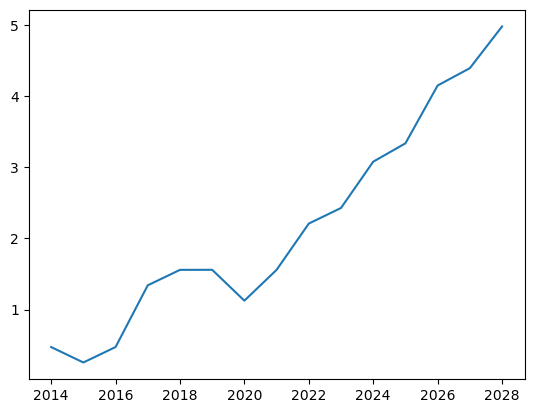

In [19]:
# 计算每一年的得分
# scores = normalized_data.dot(weights)
scores = coef_n * data['Tourism_Numbers'] + coef_local * data['Local'] + intercept

# 将得分添加到原始数据中
data['Score'] = scores + 1

# 输出包含得分的数据
print(data[['Year', 'Score']])

plt.plot(data['Year'], data['Score'])